In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 16

In [3]:
file_name = 'wheat_12_var_avg_new.csv'

def dir(file_name):
    return '../data/'+file_name

In [4]:
def seperate_X_Y(dataframe):
    return (dataframe.drop('classes', axis =1), dataframe.loc[:,'classes'])

In [5]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3

FILT = 1
FILTER = filter_method(FILT).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = 1

#will be used for test dataset in msc
reference= None

In [6]:
from sklearn.model_selection import train_test_split
def create_test_train(X, y, test_size = 0.2, shuffle = True):
    return train_test_split(X,y, test_size = test_size, shuffle=shuffle)

In [7]:
#Standard Normal Variate
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
 
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
 
    return output_data

In [8]:
# Multiplicative scatter correction
def msc(input_data, reference=None):
#     print(reference)
    ''' Perform Multiplicative scatter correction'''

    # Baseline correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean    
    if reference is None:    
        # Calculate mean
        matm = np.mean(input_data, axis=0)
    else:
        matm = reference

    # Define a new data matrix and populate it with the corrected data    
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(matm, input_data[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 

    return (output_data, matm)

In [9]:
from scipy.signal import savgol_filter, general_gaussian
def savgol(input_data):
    w = WINDOW
    p = ORDER
    d = DERIVATIVE
    
    output_data = savgol_filter(np.array(input_data), w, polyorder = p, deriv=d)
    
    return output_data

In [10]:
def preprocess_data(X,y, type="train"):
    if FILTER == "snv":
        return {"X": snv(np.array(X)), "y": y}
    elif FILTER == "msc":
        msc_output = msc(np.array(X), reference = reference if type=="test" else None)
        X = msc_output[0]
        ref = msc_output[1]
        return {
            "X": X,
            "y": y,
            "ref": ref
        }
    elif FILTER == "savgol":
        return {
            "X": savgol(X),
            "y": y
        }
    else:
        return {
            "X":X,
            "y":y
        }

In [11]:
dataset = pd.read_csv(dir(file_name))
X,y = seperate_X_Y(dataset)

In [12]:
y_set = set(y)

In [13]:
NUM_OF_CLASSES = len(y_set)

In [14]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = create_test_train(X,y)

In [15]:
preprocessed_results = preprocess_data(X_train_raw,y_train_raw)
X_train, y_train = preprocessed_results["X"], preprocessed_results["y"]

if FILTER == "msc":
    reference = preprocessed_results["ref"]
    
preprocessed_results_test = preprocess_data(X_test_raw, y_test_raw, type="test")
X_test, y_test = preprocessed_results_test["X"], preprocessed_results_test["y"]

In [16]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_test.shape)

(19353, 147, 1)
(4839, 147, 1)


In [17]:
import keras
from keras import Sequential
from keras.layers import Input, Conv1D, Flatten, Dense, MaxPooling1D

In [18]:
def createModel(input_shape,num_classes):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=5, input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=5 ))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
    
    return model

In [19]:
model = createModel(X_train.shape[1:],NUM_OF_CLASSES)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 143, 32)           192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 28, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 896)               0         
                                                                 
 dense (Dense)               (None, 1000)              897000    
                                                                 
 dense_1 (Dense)             (None, 4)                 4004      
                                                                 
Total params: 901,196
Trainable params: 901,196
Non-trainable params: 0
__________________________________________________

In [21]:
train_eva = []
test_eva = []

In [22]:
history_dataframe = pd.DataFrame() 

In [23]:
for x in range(400):
    print("\nEpoch: ",x+1)
    history = model.fit(X_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, shuffle=True)
    if history_dataframe.size == 0:
        history_dataframe = pd.DataFrame.from_dict(history.history)
    else:
        history_dataframe = pd.concat([history_dataframe,pd.DataFrame.from_dict(history.history)],axis=0,ignore_index=True)
    
    print("for training")
    train_eva.append(model.evaluate(X_train,y_train))
    print("for testing")
    test_eva.append(model.evaluate(X_test, y_test))


Epoch:  1
1210/1210 - 22s - loss: 1.2818 - accuracy: 0.3885 - 22s/epoch - 18ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 1.0617 - accuracy: 0.5686
for testing
152/152 [==============================] - 1s 4ms/step - loss: 1.0615 - accuracy: 0.5648

Epoch:  2
1210/1210 - 17s - loss: 0.8513 - accuracy: 0.6474 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.7888 - accuracy: 0.6419
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.8000 - accuracy: 0.6390

Epoch:  3
1210/1210 - 17s - loss: 0.6106 - accuracy: 0.7515 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.5143 - accuracy: 0.7986
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.5294 - accuracy: 0.7936

Epoch:  4
1210/1210 - 17s - loss: 0.5107 - accuracy: 0.7946 - 17s/epoch - 14ms/step
for training
605/605 [=============================

605/605 [==============================] - 3s 4ms/step - loss: 0.0842 - accuracy: 0.9729
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0968 - accuracy: 0.9661

Epoch:  30
1210/1210 - 17s - loss: 0.0937 - accuracy: 0.9681 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0977 - accuracy: 0.9651
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.1126 - accuracy: 0.9597

Epoch:  31
1210/1210 - 17s - loss: 0.0910 - accuracy: 0.9672 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0901 - accuracy: 0.9683
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.1023 - accuracy: 0.9665

Epoch:  32
1210/1210 - 17s - loss: 0.0896 - accuracy: 0.9687 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0763 - accuracy: 0.9746
for testing
152/152 [=======================

152/152 [==============================] - 1s 4ms/step - loss: 0.0593 - accuracy: 0.9785

Epoch:  58
1210/1210 - 17s - loss: 0.0564 - accuracy: 0.9791 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0341 - accuracy: 0.9888
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0458 - accuracy: 0.9853

Epoch:  59
1210/1210 - 17s - loss: 0.0549 - accuracy: 0.9808 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0559 - accuracy: 0.9796
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0718 - accuracy: 0.9762

Epoch:  60
1210/1210 - 17s - loss: 0.0556 - accuracy: 0.9806 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0406 - accuracy: 0.9867
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0528 - accuracy: 0.9833

Epoch:  61
1210/1210 - 17s - loss: 0.0504 -

1210/1210 - 17s - loss: 0.0414 - accuracy: 0.9859 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0280 - accuracy: 0.9901
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0363 - accuracy: 0.9884

Epoch:  87
1210/1210 - 17s - loss: 0.0445 - accuracy: 0.9840 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0451 - accuracy: 0.9842
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0551 - accuracy: 0.9802

Epoch:  88
1210/1210 - 17s - loss: 0.0391 - accuracy: 0.9859 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0364 - accuracy: 0.9867
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0539 - accuracy: 0.9835

Epoch:  89
1210/1210 - 17s - loss: 0.0419 - accuracy: 0.9848 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 

605/605 [==============================] - 3s 5ms/step - loss: 0.0281 - accuracy: 0.9899
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0403 - accuracy: 0.9857

Epoch:  115
1210/1210 - 19s - loss: 0.0322 - accuracy: 0.9883 - 19s/epoch - 16ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.1300 - accuracy: 0.9523
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.1691 - accuracy: 0.9450

Epoch:  116
1210/1210 - 20s - loss: 0.0308 - accuracy: 0.9887 - 20s/epoch - 17ms/step
for training
605/605 [==============================] - 3s 6ms/step - loss: 0.0192 - accuracy: 0.9932
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0313 - accuracy: 0.9899

Epoch:  117
1210/1210 - 19s - loss: 0.0323 - accuracy: 0.9886 - 19s/epoch - 16ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0317 - accuracy: 0.9884
for testing
152/152 [====================

605/605 [==============================] - 3s 4ms/step - loss: 0.0342 - accuracy: 0.9869
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0496 - accuracy: 0.9828

Epoch:  143
1210/1210 - 17s - loss: 0.0262 - accuracy: 0.9910 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0163 - accuracy: 0.9941
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0363 - accuracy: 0.9895

Epoch:  144
1210/1210 - 19s - loss: 0.0251 - accuracy: 0.9915 - 19s/epoch - 15ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0609 - accuracy: 0.9769
for testing
152/152 [==============================] - 1s 6ms/step - loss: 0.0810 - accuracy: 0.9733

Epoch:  145
1210/1210 - 19s - loss: 0.0261 - accuracy: 0.9898 - 19s/epoch - 15ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0117 - accuracy: 0.9956
for testing
152/152 [====================

605/605 [==============================] - 3s 5ms/step - loss: 0.0128 - accuracy: 0.9955
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0257 - accuracy: 0.9903

Epoch:  171
1210/1210 - 17s - loss: 0.0172 - accuracy: 0.9936 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0072 - accuracy: 0.9979
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0272 - accuracy: 0.9930

Epoch:  172
1210/1210 - 15s - loss: 0.0208 - accuracy: 0.9929 - 15s/epoch - 13ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0319 - accuracy: 0.9881
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0486 - accuracy: 0.9853

Epoch:  173
1210/1210 - 16s - loss: 0.0233 - accuracy: 0.9917 - 16s/epoch - 13ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0081 - accuracy: 0.9973
for testing
152/152 [====================

605/605 [==============================] - 3s 4ms/step - loss: 0.0092 - accuracy: 0.9968
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0264 - accuracy: 0.9913

Epoch:  199
1210/1210 - 16s - loss: 0.0202 - accuracy: 0.9926 - 16s/epoch - 13ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0365 - accuracy: 0.9868
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0636 - accuracy: 0.9816

Epoch:  200
1210/1210 - 16s - loss: 0.0201 - accuracy: 0.9926 - 16s/epoch - 13ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0085 - accuracy: 0.9968
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0273 - accuracy: 0.9919

Epoch:  201
1210/1210 - 17s - loss: 0.0172 - accuracy: 0.9935 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0172 - accuracy: 0.9931
for testing
152/152 [====================

605/605 [==============================] - 3s 4ms/step - loss: 0.0212 - accuracy: 0.9917
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0466 - accuracy: 0.9864

Epoch:  227
1210/1210 - 17s - loss: 0.0141 - accuracy: 0.9950 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0126 - accuracy: 0.9951
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0364 - accuracy: 0.9895

Epoch:  228
1210/1210 - 17s - loss: 0.0191 - accuracy: 0.9939 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0071 - accuracy: 0.9981
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0296 - accuracy: 0.9915

Epoch:  229
1210/1210 - 18s - loss: 0.0121 - accuracy: 0.9959 - 18s/epoch - 15ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0112 - accuracy: 0.9955
for testing
152/152 [====================

605/605 [==============================] - 3s 4ms/step - loss: 0.0054 - accuracy: 0.9980
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0262 - accuracy: 0.9928

Epoch:  255
1210/1210 - 17s - loss: 0.0168 - accuracy: 0.9942 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0044 - accuracy: 0.9984
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0250 - accuracy: 0.9919

Epoch:  256
1210/1210 - 17s - loss: 0.0177 - accuracy: 0.9941 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0056 - accuracy: 0.9979
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0252 - accuracy: 0.9930

Epoch:  257
1210/1210 - 17s - loss: 0.0075 - accuracy: 0.9972 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0049 - accuracy: 0.9987
for testing
152/152 [====================

605/605 [==============================] - 3s 5ms/step - loss: 0.0149 - accuracy: 0.9944
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0372 - accuracy: 0.9897

Epoch:  283
1210/1210 - 17s - loss: 0.0117 - accuracy: 0.9956 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0102 - accuracy: 0.9962
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0362 - accuracy: 0.9909

Epoch:  284
1210/1210 - 17s - loss: 0.0154 - accuracy: 0.9943 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0050 - accuracy: 0.9987
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0294 - accuracy: 0.9926

Epoch:  285
1210/1210 - 17s - loss: 0.0124 - accuracy: 0.9960 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0114 - accuracy: 0.9955
for testing
152/152 [====================

605/605 [==============================] - 3s 4ms/step - loss: 0.0036 - accuracy: 0.9989
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0284 - accuracy: 0.9928

Epoch:  311
1210/1210 - 18s - loss: 0.0145 - accuracy: 0.9951 - 18s/epoch - 15ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0143 - accuracy: 0.9948
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0447 - accuracy: 0.9890

Epoch:  312
1210/1210 - 18s - loss: 0.0133 - accuracy: 0.9952 - 18s/epoch - 15ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0166 - accuracy: 0.9940
for testing
152/152 [==============================] - 1s 6ms/step - loss: 0.0528 - accuracy: 0.9874

Epoch:  313
1210/1210 - 18s - loss: 0.0091 - accuracy: 0.9967 - 18s/epoch - 15ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0050 - accuracy: 0.9985
for testing
152/152 [====================

605/605 [==============================] - 3s 4ms/step - loss: 0.0071 - accuracy: 0.9972
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0324 - accuracy: 0.9919

Epoch:  339
1210/1210 - 16s - loss: 0.0132 - accuracy: 0.9956 - 16s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0018 - accuracy: 0.9997
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0235 - accuracy: 0.9934

Epoch:  340
1210/1210 - 16s - loss: 0.0086 - accuracy: 0.9972 - 16s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0019 - accuracy: 0.9995
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0228 - accuracy: 0.9944

Epoch:  341
1210/1210 - 16s - loss: 0.0101 - accuracy: 0.9966 - 16s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0032 - accuracy: 0.9990
for testing
152/152 [====================

605/605 [==============================] - 3s 5ms/step - loss: 0.0055 - accuracy: 0.9981
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0322 - accuracy: 0.9921

Epoch:  367
1210/1210 - 17s - loss: 0.0138 - accuracy: 0.9954 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0032 - accuracy: 0.9991
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0288 - accuracy: 0.9930

Epoch:  368
1210/1210 - 17s - loss: 0.0059 - accuracy: 0.9980 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0079 - accuracy: 0.9971
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0285 - accuracy: 0.9924

Epoch:  369
1210/1210 - 17s - loss: 0.0155 - accuracy: 0.9946 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0052 - accuracy: 0.9980
for testing
152/152 [====================

605/605 [==============================] - 3s 4ms/step - loss: 9.6032e-04 - accuracy: 0.9999
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0228 - accuracy: 0.9944

Epoch:  395
1210/1210 - 17s - loss: 0.0140 - accuracy: 0.9965 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0012 - accuracy: 0.9999
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0273 - accuracy: 0.9932

Epoch:  396
1210/1210 - 17s - loss: 0.0053 - accuracy: 0.9983 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0018 - accuracy: 0.9996
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0220 - accuracy: 0.9938

Epoch:  397
1210/1210 - 17s - loss: 0.0091 - accuracy: 0.9967 - 17s/epoch - 14ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0018 - accuracy: 0.9997
for testing
152/152 [================

In [24]:
history_dataframe

,loss,accuracy
0,1.281798,0.388467
1,0.851255,0.647445
2,0.610582,0.751511
3,0.510676,0.794605
4,0.429842,0.831964
...,...,...
395,0.005344,0.998347
396,0.009082,0.996745
397,0.006634,0.997985
398,0.007894,0.997830


In [25]:
train_eva_df = pd.DataFrame(train_eva,columns=['loss','accuracy'])
test_eva_df = pd.DataFrame(test_eva,columns=['loss','accuracy'])

In [26]:
def plot_graph(df,title,xlabel,ylabel,values=['loss'],legends=[]):
    
    for value in values:
        epoch_count = range(1, len(df.index) + 1)
        plt.plot(epoch_count, df[value].tolist())
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if legends==[]:
        legends = values
    plt.legend(legends, loc='upper left')
    plt.show()

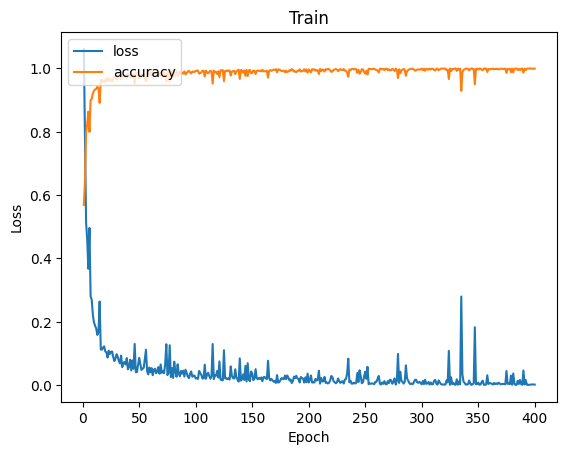

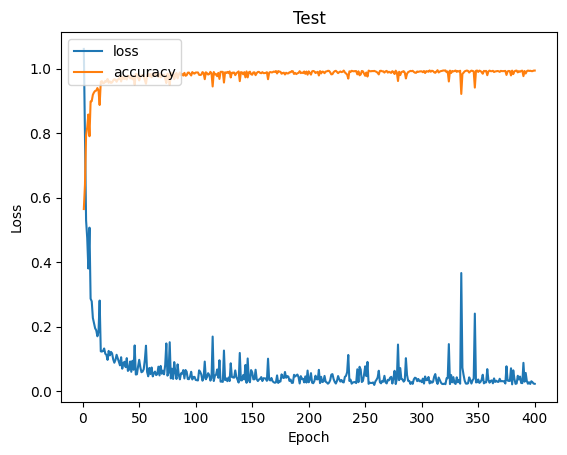

In [27]:
plot_graph(train_eva_df,'Train','Epoch','Loss',['loss','accuracy'])
plot_graph(test_eva_df,'Test','Epoch','Loss',['loss','accuracy'])

In [28]:
train_eva_df['accuracy'].max()

0.9999483227729797

In [30]:
train_eva_df.idxmax()

loss          0
accuracy    382
dtype: int64

In [29]:
test_eva_df['accuracy'].max()

0.9954535961151123

In [31]:
test_eva_df.idxmax()

loss          0
accuracy    313
dtype: int64